# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# Imports here
import matplotlib.pyplot as plt

import torch
from torch import nn as nn
from torch import optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
import numpy as np
from collections import OrderedDict

from workspace_utils import active_session
from PIL import Image

import seaborn as sb
import pandas as pd


import time

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# For the train transform:
# Randomly rotate the images
# Randomly resize and crop
# Randomly flip the image
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

# For the validation and test transforms:
# Resize and crop
valid_transforms = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])


test_transforms = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])


# Load the datasets with ImageFolder
train_datasets = datasets.ImageFolder(train_dir, transform = train_transforms)
valid_datasets = datasets.ImageFolder(valid_dir, transform = valid_transforms)
test_datasets = datasets.ImageFolder(test_dir, transform = test_transforms)

batch_size=32
# Using the image datasets and the trainforms, define the dataloaders
train_dataloaders = torch.utils.data.DataLoader(train_datasets, batch_size=batch_size, shuffle=True)
valid_dataloaders = torch.utils.data.DataLoader(valid_datasets, batch_size=batch_size, shuffle=True)
test_dataloaders = torch.utils.data.DataLoader(test_datasets, batch_size=batch_size)

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [4]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
    
print(cat_to_name)

{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pocket orchid', '54': 's

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [5]:
# Load a pretrained network (densenet161)
# Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout


# Load a pretrained model (densenet)
model = models.vgg19(pretrained=True)
# Freeze the parameters so we dont backpropagate through them
for param in model.parameters():
    param.requires_grad = False

# Create our classifier to replace the current one in the model
model.classifier = nn.Sequential(nn.Linear(25088, 500),
                                 nn.ReLU(),
                                 nn.Dropout(0.5),
                                 nn.Linear(500, 102),
                                 nn.LogSoftmax(dim=1))

print(model)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.torch/models/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:10<00:00, 56798568.56it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [6]:
# Train the classifier layers using backpropagation using the pre-trained network to get the features
# Track the loss and accuracy on the validation set to determine the best hyperparameters

# Use the GPU if its available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the loss function
criterion = nn.NLLLoss()

# Define the learning rate
learning_rate = .001

# Define the optimizer (only train the classifier parameters leaving the feature parameters frozen)
optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate)

#optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define the training epochs
epochs = 12

# Set the model to the device for training
model.to(device)

start_time = time.time()

# Keep a record of the test vs validation losses to graph the learning curve
train_losses, test_losses = [], []
# With an active session train our model
with active_session():
    
    # Create the training loop
    for e in range(epochs):
        # Define the training loss for each epoch
        training_loss = 0
        
        for images, labels in train_dataloaders:            
            # Move the image and label tensors to the default device
            images, labels = images.to(device), labels.to(device)
            
            # Zero the gradients since they accumulate
            optimizer.zero_grad()
            
            #image = images.view(images.shape[0], -1)
            
            #print("test")

            
            # Get the log probability from the model
            logps = model(images)

            # Get the loss
            loss = criterion(logps, labels)

            # Backpropagate
            loss.backward()

            # Gradient Descent
            optimizer.step()

            # Keep track of the training loss
            training_loss += loss.item()
        else:
            # Keep track of the validation loss and accuracy
            validation_loss = 0
            accuracy = 0
            
            #print("validation")
            
            # Set the model to evaluation mode. This will turn off the dropout functionality
            model.eval()
            
            # Turn off the gradients for validation
            with torch.no_grad():
                # Create the validation loop
                for images, labels in valid_dataloaders:
                    # Move the image and label tensors to the default device
                    images, labels = images.to(device), labels.to(device)
                    
                    #images.resize_(images.shape[0], -1)
                    
                    # Get the log probability 
                    logps = model(images)
                    
                    # Get the loss
                    loss = criterion(logps, labels)
                    
                    # Get probability from the model
                    ps = torch.exp(logps)
                    
                    # Get the top class from the predictions
                    top_p, top_class = ps.topk(1, dim=1)

                    equals = top_class == labels.view(*top_class.shape)
                    
                    # Get the accuracy for the prediction
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
                    # Keep track of the validation loss
                    validation_loss += loss.item()
                    
            # Set the model back to train mode
            model.train()
            elapsed_time = time.time() - start_time  
            
            # Update the training and validation losses to graph the learning curve
            train_losses.append(training_loss/len(train_dataloaders))
            test_losses.append(validation_loss/len(valid_dataloaders))
            
            print("Epoch: {}\n".format(e),
                  "Training Loss: {}\n".format(training_loss/len(train_dataloaders)),
                  "Validation Loss: {}\n".format(validation_loss/len(valid_dataloaders)),
                  "Accuracy: {}\n".format(accuracy/len(valid_dataloaders) * 100),
                  "Time: {}\n".format(elapsed_time))    

Epoch: 0
 Training Loss: 3.2702707691890436
 Validation Loss: 1.4200358734681056
 Accuracy: 63.581730769230774
 Time: 199.54876351356506

Epoch: 1
 Training Loss: 2.1567500294708624
 Validation Loss: 0.9719943358347967
 Accuracy: 73.26388886341681
 Time: 386.51458859443665

Epoch: 2
 Training Loss: 1.900756934793984
 Validation Loss: 0.7924230282123272
 Accuracy: 78.91292732495529
 Time: 573.2859818935394

Epoch: 3
 Training Loss: 1.7917319620527872
 Validation Loss: 0.751983255147934
 Accuracy: 79.39369655572452
 Time: 760.3286974430084

Epoch: 4
 Training Loss: 1.7090644566024222
 Validation Loss: 0.6996695422209226
 Accuracy: 79.87446578649374
 Time: 947.2037739753723

Epoch: 5
 Training Loss: 1.6453435720466987
 Validation Loss: 0.6332044372191796
 Accuracy: 82.67895304239713
 Time: 1134.1968357563019

Epoch: 6
 Training Loss: 1.574587029364051
 Validation Loss: 0.6150677089507763
 Accuracy: 81.08974351332738
 Time: 1321.3622488975525

Epoch: 7
 Training Loss: 1.5776521354186825
 V

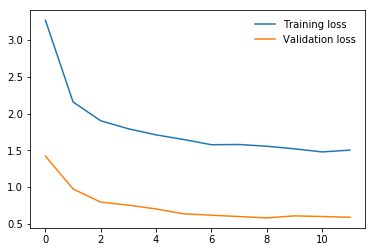

In [7]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [8]:
# Do validation on the test set
# Keep track of the test loss and accuracy
test_loss = 0
accuracy = 0

# Use the GPU if its available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)

# Set the model to evaluation mode to turn off the dropout
model.eval()

# Turn off the gradients for validation
with torch.no_grad():
    # Setup the validation loop
    for images, labels in test_dataloaders:
        # Move the images and labels to the current device
        images, labels = images.to(device), labels.to(device)
        
        # Get the output of the model
        output = model(images)
        
        # Get the loss
        loss = criterion(output, labels)
        
        # Get the probability from the model
        ps = torch.exp(output)
        
        # Get the top class from the predictions
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        
        # Get the accuracy
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
        # Keep track of the loss
        test_loss = loss.item()
    # Set the model back to train mode
    model.train()
    
    
    print("Validation Loss: {}".format(test_loss/len(test_dataloaders)),
          "Accuracy: {}".format(accuracy/len(test_dataloaders) * 100))

Validation Loss: 0.0696638639156635 Accuracy: 82.28112344558423


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [25]:
# TODO: Save the checkpoint
# Before saving the model set it to cpu to aviod loading issues later
device = torch.device('cpu')
model.to(device)

# Save the train image dataset
model.class_to_idx = train_datasets.class_to_idx

# Save other hyperparamters
checkpoint = {'input_size': 25088,
              'hidden_layer_size': 500,
              'output_size': 102,
              'arch': 'densenet',
              'learning_rate': learning_rate,
              'batch_size': batch_size,
              'classifier' : model.classifier,
              'epochs': epochs,
              'criterion': criterion,
              'optimizer': optimizer.state_dict(),
              'state_dict': model.state_dict(),
              'class_to_idx': model.class_to_idx}

torch.save(checkpoint, 'myModelCheckpoint.pth')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [26]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_model(filepath):
    # Load the model and force the tensors to be on the CPU
    checkpoint = torch.load(filepath)
    model = models.vgg19(pretrained=True)

    model.classifier = checkpoint['classifier'] 
    model.load_state_dict(checkpoint['state_dict'])
    model.class_to_idx = checkpoint['class_to_idx']

    #optimizer.load_state_dict(checkpoint['optimizer'])

    # Freeze the parameters so we dont backpropagate through them
    for param in model.parameters():
        param.requires_grad = False

    #return model, optimizer
    return model

In [27]:
# Load the model with the loading function
file_name = 'myModelCheckpoint.pth'

#saved_model, saved_optimizer = load_model(file_name)
saved_model = load_model(file_name)

print(saved_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [28]:
def process_image(image_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # Process a PIL image for use in a PyTorch model
    # Open the image
    img = Image.open(image_path)
    
    # Resize the image
    img = img.resize((256,256))
    
    # Crop the image
    img = img.crop((0,0,224,224))
    
    # Get the color channels
    img = np.array(img)/255
    
    # Normalize the images
    means = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    img = (img - means) / std
          
    # Transpose the colors
    img = img.transpose((2, 0, 1))
          
    return img

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [29]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

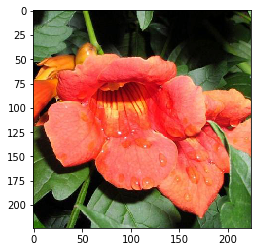

In [30]:
result = process_image('flowers/test/101//image_07949.jpg')

imshow(result)

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [33]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    # Use the GPU if its available
    #device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to('cpu')
    
    #Switch the model to evaluation mode to turn off dropout
    model.eval()
    
    with torch.no_grad():
    # Implement the code to predict the class from an image file    
        # Processs the image
        image = process_image(image_path)

        # We need a tensor for the model so change the image to a np.Array and then a tensor
        image = torch.from_numpy(np.array([image])).float()
        image.to('cpu')

        # Use the model to make a prediction
        logps = model(image)
        ps = torch.exp(logps)

        # Get the top 5 probabilities and classes. This is returned as a tenosr of lists
        p, classes = ps.topk(topk, dim=1)

        # Switch the model back to training mode
        #model.train()
        
        # Get the first items in the tensor list to get the list of probs and classes
        top_p = p.tolist()[0]
        top_classes = classes.tolist()[0]
        
        # Reverse the categories dictionary
        idx_to_class = {v:k for k, v in model.class_to_idx.items()}
        
        # Get the lables from the json file
        labels = []
        for c in top_classes:
            labels.append(cat_to_name[idx_to_class[c]])
    
        return top_p, labels

In [34]:
prob, classes = predict('flowers/test/77/image_00005.jpg', saved_model)
print(prob)
print(classes)

[1.0, 2.5822296774793974e-13, 2.5147539148176294e-14, 8.194272964703354e-15, 2.6702548490767104e-15]
['passion flower', 'lenten rose', 'barbeton daisy', 'king protea', 'artichoke']


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

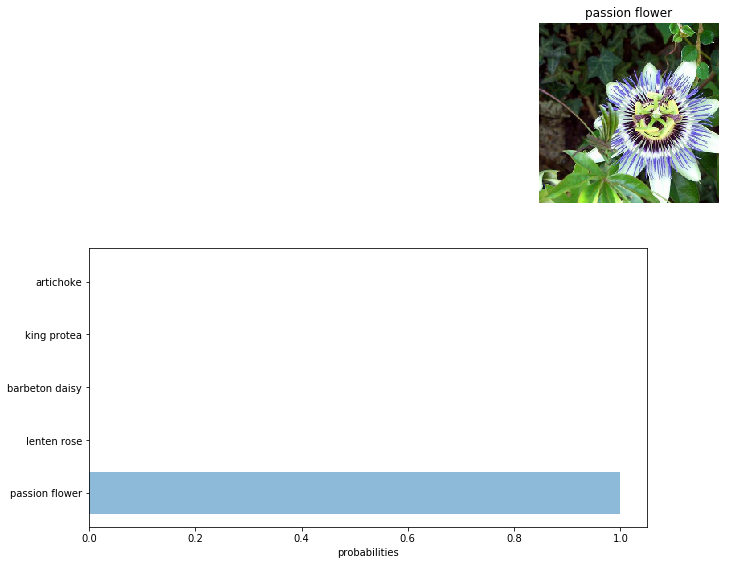

In [38]:
# Display an image along with the top 5 classes
# Create a plot that will have the image and the bar graph
fig = plt.figure(figsize = [10,5])

# Create the axes for the flower image 
ax = fig.add_axes([.5, .4, .5, .5])

# Process the image and show it
result = process_image('flowers/test/77/image_00005.jpg')
ax = imshow(result, ax)
ax.axis('off')
index = 77

ax.set_title(cat_to_name[str(index)])


# Make a prediction on the image
predictions, classes = predict('flowers/test/77/image_00005.jpg', model)


# Make a bar graph
# Create the axes for the bar graph
ax1 = fig.add_axes([0, -.5, .775, .775])

# Get the range for the probabilities
y_pos = np.arange(len(classes))

# Plot as a horizontal bar graph
plt.barh(y_pos, predictions, align='center', alpha=0.5)
plt.yticks(y_pos, classes)
plt.xlabel('probabilities')
plt.show()